In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import random
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime
import matplotlib.pyplot as plt
#import plotly.express as px
import glob
from tqdm import tqdm

# Using plotly.express
import plotly.express as px

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')


In [2]:
url = 'data/australia_viirs_prepared.csv.gz'
aus_fires = pd.read_csv(url,parse_dates=['time'])
aus_fires.shape
aus_fires.head()

(1323312, 10)

,latitude,longitude,time,fire_count,confidence,est_brightness,frp,est_fire_area,loc_count,ranking
0,-29.5,123.9,2019-02-16,315,79,331.6,358982.2,103.9,4,0.694892
1,-31.4,123.7,2019-11-10,680,71,324.5,24134.6,207.1,11,0.667022
2,-32.4,123.5,2020-01-02,474,86,335.9,11099.8,138.2,12,0.601851
3,-27.6,144.3,2013-01-13,566,68,313.9,13568.5,185.4,2,0.599751
4,-26.3,150.7,2013-10-08,551,66,311.2,10181.1,188.4,51,0.589020


In [3]:
def filterLocation(aus_fires,latitude,longitude):
    filtered = aus_fires[(aus_fires.latitude == latitude)&(aus_fires.longitude == longitude)]
    return filtered

In [4]:
lat = -33.4
lng = 116.9
filtered = filterLocation(aus_fires,lat,lng)

In [5]:
df = filtered.filter(['time','ranking'])
df.rename({'time': 'ds'}, axis=1, inplace=True)
df.rename({'ranking': 'y'}, axis=1, inplace=True)
df

,ds,y
1004,2017-06-05,0.401483
13113,2015-04-13,0.350226
50011,2017-04-13,0.307113
50945,2014-05-02,0.306716
73992,2016-03-21,0.293541
...,...,...
1009198,2019-05-03,0.240347
1114808,2015-04-27,0.214282
1125555,2017-04-10,0.210220
1155649,2014-04-03,0.201584


In [6]:
# RESAMPLE DATA FROM DAILY TO MONTHLY
df_m = df.copy()
df_m.set_index('ds', inplace=True)
df_m.index = pd.to_datetime(df_m.index)
df_m = df_m.resample('1M').mean()

In [7]:
df_m

,y
ds,
2012-05-31,0.254521
2012-06-30,NaN
2012-07-31,NaN
2012-08-31,NaN
2012-09-30,NaN
...,...
2021-01-31,NaN
2021-02-28,NaN
2021-03-31,NaN


In [10]:
df_m['y'] = df_m['y'].fillna(0)

In [11]:
df_m

,y
ds,
2012-05-31,0.254521
2012-06-30,0.000000
2012-07-31,0.000000
2012-08-31,0.000000
2012-09-30,0.000000
...,...
2021-01-31,0.000000
2021-02-28,0.000000
2021-03-31,0.000000


In [12]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm

<AxesSubplot:xlabel='ds'>

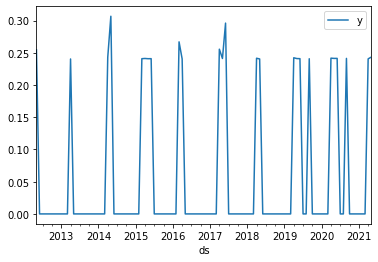

In [13]:
df_m.plot()

In [15]:
model=sm.tsa.arima.ARIMA(df_m['y'],order=(1,1,1))
model_fit=model.fit()

<AxesSubplot:xlabel='ds'>

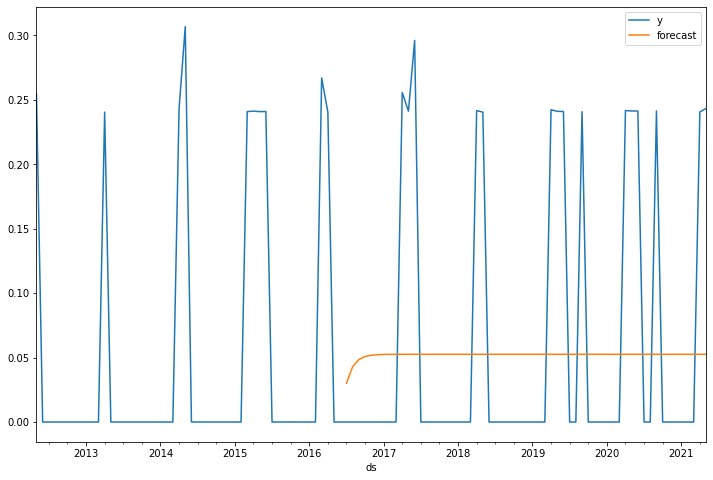

In [16]:
df_m['forecast']=model_fit.predict(start=50,end=109,dynamic=True)
df_m[['y','forecast']].plot(figsize=(12,8))

In [18]:
model=sm.tsa.statespace.SARIMAX(df_m['y'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/home/due/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='ds'>

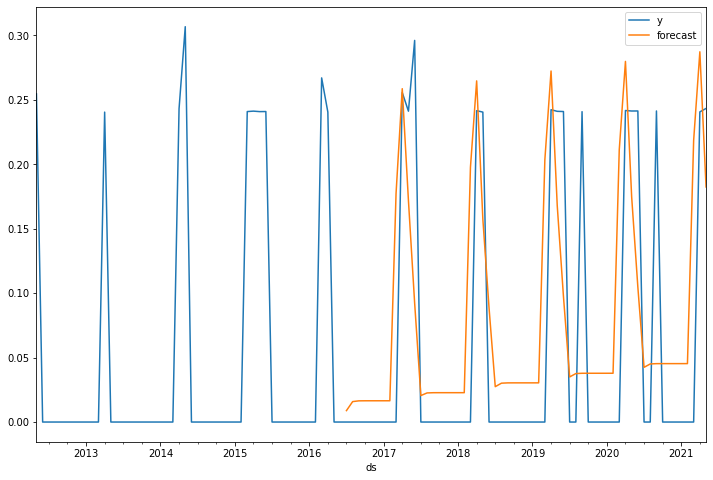

In [20]:
df_m['forecast']=results.predict(start=50,end=109,dynamic=True)
df_m[['y','forecast']].plot(figsize=(12,8))